In [ ]:
from keras.applications.vgg16 import VGG16
model=VGG16()

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download -d abhranta/brain-tumor-detection-mri

Dataset URL: https://www.kaggle.com/datasets/abhranta/brain-tumor-detection-mri
License(s): unknown
brain-tumor-detection-mri.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

<ipython-input-5-4addd0ae159c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [ ]:
from zipfile import ZipFile
file_name = "/content/brain-tumor-detection-mri.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# Load images from 'yes' folder (Tumor present)
os.chdir('/content/Brain_Tumor_Detection/yes')
X = []
y = []
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append('Y')  # Append label 'Y' for tumor presence

# Load images from 'no' folder (No tumor)
os.chdir('/content/Brain_Tumor_Detection/no')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append('N')  # Append label 'N' for no tumor

# Check the length of images and labels
print(f"Number of images: {len(X)}")
print(f"Number of labels: {len(y)}")


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Number of images: 3000
Number of labels: 3000


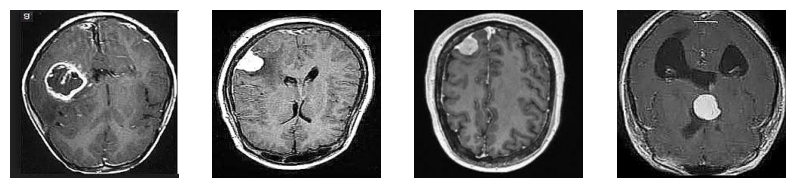

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
#preprocessing steps
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [ ]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (2010, 224, 224, 3)
X_test Shape:  (990, 224, 224, 3)
y_train Shape:  (2010, 2)
y_test Shape:  (990, 2)


In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1625s 26s/step - accuracy: 0.7134 - loss: 3.0758 - val_accuracy: 0.9566 - val_loss: 0.1148
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1633s 26s/step - accuracy: 0.9642 - loss: 0.1077 - val_accuracy: 0.9778 - val_loss: 0.0690
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1665s 26s/step - accuracy: 0.9755 - loss: 0.0647 - val_accuracy: 0.9818 - val_loss: 0.0675
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1611s 26s/step - accuracy: 0.9889 - loss: 0.0257 - val_accuracy: 0.9758 - val_loss: 0.1063
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1650s 26s/step - accuracy: 0.9862 - loss: 0.0358 - val_accuracy: 0.9626 - val_loss: 0.1214


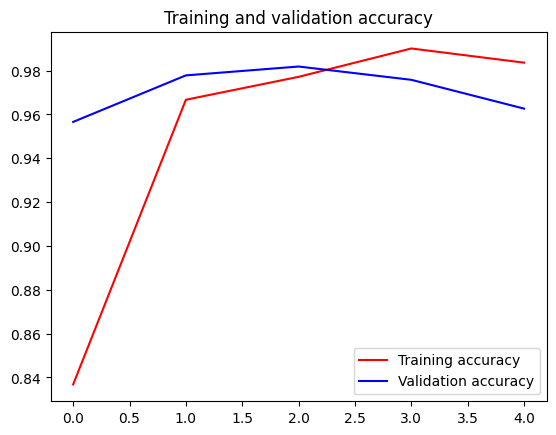

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 573s 18s/step


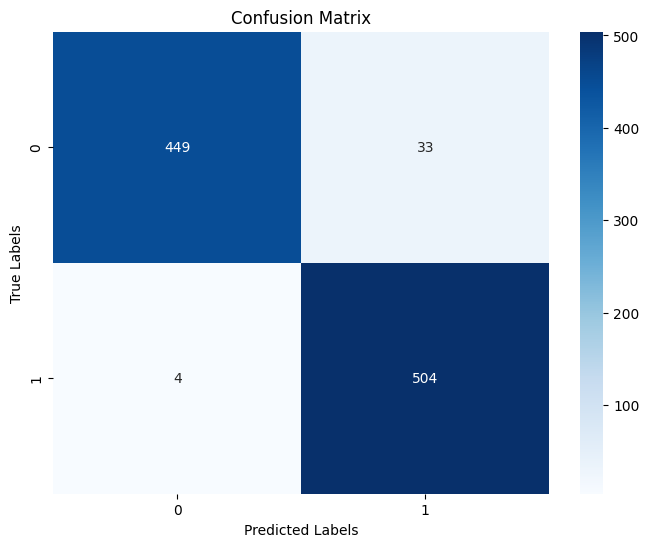

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes)

# Recall
recall = recall_score(y_true, y_pred_classes)

# F1 Score
f1 = f1_score(y_true, y_pred_classes)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Classification report
report = classification_report(y_true, y_pred_classes, target_names=['No Tumor', 'Tumor'])
print(report)


Accuracy: 0.9626
Precision: 0.9385
Recall: 0.9921
F1 Score: 0.9646
              precision    recall  f1-score   support

    No Tumor       0.99      0.93      0.96       482
       Tumor       0.94      0.99      0.96       508

    accuracy                           0.96       990
   macro avg       0.96      0.96      0.96       990
weighted avg       0.96      0.96      0.96       990

